# Setup

In [1]:
%matplotlib widget
%matplotlib inline

import ipywidgets as widgets
interact = widgets.interact
import numpy as np
import matplotlib.pyplot as plt

import pathlib
import torch as t
from tqdm.notebook import tqdm
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
rootdir=pathlib.Path("./saved_models/")
rootdir.mkdir(exist_ok=True)

from IPython.display import display, clear_output

from model_fns import UncorrelatedTMS, CorrelatedTMS, AntiCorrelatedTMS, ComposedFeatureTMS, ToyModelConfig
from autoencoder_fns import AutoEncoder, AutoEncoderConfig
from plot_fns import w_cossim, w_enc

saes = []

# Plotting

In [2]:
def plot_sae_imshows(sae, model, sae_log):
    fig = plt.figure(figsize=(5, 7.5))
    
    cax1 = fig.add_axes([0.05, 0.97, 0.4, 0.03])
    cax2 = fig.add_axes([0.55, 0.97, 0.4, 0.03])
    ax1_1 = fig.add_axes([0.025, 0.95-0.19*1, 0.45, 0.16])
    ax1_2 = fig.add_axes([0.025, 0.95-0.19*2, 0.45, 0.16])
    ax1_3 = fig.add_axes([0.025, 0.95-0.19*3, 0.45, 0.16])
    ax1_4 = fig.add_axes([0.025, 0.95-0.19*4, 0.45, 0.16])
    ax1_5 = fig.add_axes([0.025, 0.95-0.19*5, 0.45, 0.16])
    
    ax2_1 = fig.add_axes([0.525, 0.95-0.19*1, 0.45, 0.16])
    ax2_2 = fig.add_axes([0.525, 0.95-0.19*2, 0.45, 0.16])
    ax2_3 = fig.add_axes([0.525, 0.95-0.19*3, 0.45, 0.16])
    ax2_4 = fig.add_axes([0.525, 0.95-0.19*4, 0.45, 0.16])
    ax2_5 = fig.add_axes([0.525, 0.95-0.19*5, 0.45, 0.16])
    
    axs_left = [ax1_1, ax1_2, ax1_3, ax1_4, ax1_5]
    axs_right = [ax2_1, ax2_2, ax2_3, ax2_4, ax2_5]
    # print(sae_log.keys())
    # print(sae_log['monosemanticity'])
    
    for i, axs in enumerate(zip(axs_left, axs_right)):
        actvecs, argsacts = w_enc(model, sae, instance=i)
        cossim, args = w_cossim(model.W, sae.W_dec[i], sort=argsacts)
    
        axL, axR = axs

        set1, set2 = model.cfg.feat_sets
        cols = actvecs.squeeze().shape[1]
        activations1 = axL.imshow(actvecs.squeeze()[:set1], vmin=0, vmax=1, cmap='hot')
        activations2 = axL.imshow(actvecs.squeeze()[set1:], vmin=0, vmax=1, cmap='bone', extent=(-0.5, cols-0.5, set1+set2-0.5, set1-0.5, ))
        coss1 = axR.imshow(cossim.squeeze()[:set1], vmin=-1, vmax=1, cmap='RdBu_r')
        coss2 = axR.imshow(cossim.squeeze()[set1:], vmin=-1, vmax=1, cmap='PuOr_r', extent=(-0.5, cols-0.5, set1+set2-0.5, set1-0.5, ))
    
        axL.set_ylim(set1+set2-0.5, -0.5)
        axR.set_ylim(set1+set2-0.5, -0.5)
        if i == 0:
            plt.colorbar(activations1, cax=cax1, orientation='horizontal')
            plt.colorbar(coss1, cax=cax2, orientation='horizontal')
            cax1.text(0.5, 1.05, r'$\mathrm{ReLU}(I\,W\,W_{\mathrm{enc}} + b_{\mathrm{enc}})$', ha='center', va='bottom', transform=cax1.transAxes)
            cax2.text(0.5, 1.05, r'$\mathrm{Cos-sim}_{ij}(W_{ik}, W_{\rm{dec}, jk})$', ha='center', va='bottom', transform=cax2.transAxes)
    
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.75)
        axL.text(0.98, 0.97, f'{sae_log["monosemanticity"][-1][i]:.2f}', ha='right', va='top', bbox=props, transform=axL.transAxes)

# Small composed models (8 features, 2 sets)

## Uncorrelated feature amplitudes

### Model and simple SAEs

In [3]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
feats_per_set = 4
cfg = ToyModelConfig(hidden_size=feats_per_set,
                     feat_sets=(feats_per_set,feats_per_set),
                     batches=10000, 
                     batch_size=1000,
                     correlated_feature_indices=(1,1),
                     correlated_feature_boost=0,
                     set_magnitude_correlation=0,
                     active_features_per_draw=1, # seems important for getting composed pairs.
                     )

model = ComposedFeatureTMS(cfg).to(device)
try:
    print('attempting to load')
    model.load(outdir, run_name=cfg.run_name)
except:
    print('training')
    model.train(outdir=outdir)

          y1        y2        y3        y4        
x1        0.0625    0.0625    0.0625    0.0625    
x2        0.0625    0.0625    0.0625    0.0625    
x3        0.0625    0.0625    0.0625    0.0625    
x4        0.0625    0.0625    0.0625    0.0625    
attempting to load


In [4]:
#We can do stuff like this with the probability table!
# cfg = ToyModelConfig(hidden_size=feats_per_set,
#                      feat_sets=(feats_per_set,feats_per_set),
#                      batches=10000, 
#                      batch_size=1000,
#                      correlated_feature_indices=(1,1),
#                      correlated_feature_boost=0,
#                      set_magnitude_correlation=0,
#                      active_features_per_draw=1, # seems important for getting composed pairs.
#                      onehot_probability=0.1
#                      )

# model = ComposedFeatureTMS(cfg).to(device)

# prob_table = model.get_prob_table()

# prob_table[0,0] += prob_table[0,1]
# prob_table[0,0] += prob_table[0,2]
# prob_table[0,0] += prob_table[0,3]
# prob_table[0,1:4] = 0


# model.set_prob_table(prob_table)


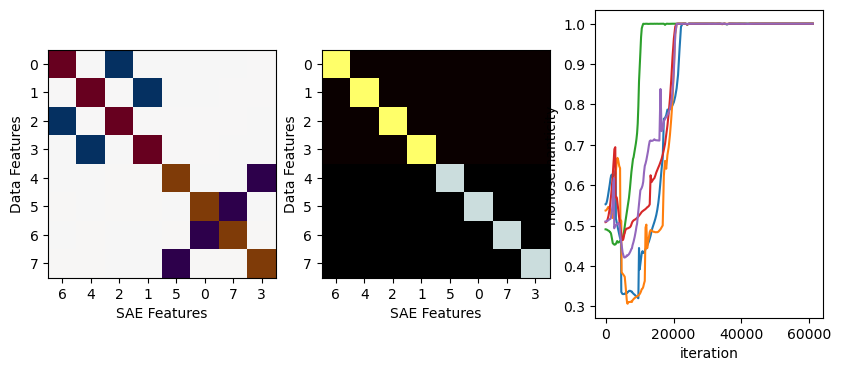

In [7]:
lr=3e-4
l1_coeff = 0.3
d_sae = feats_per_set*2

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 64_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

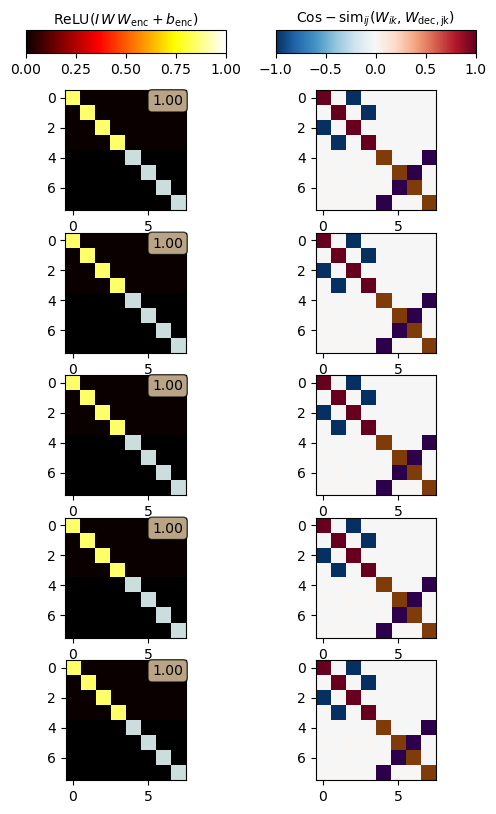

In [8]:
plot_sae_imshows(single_sae, model, sae_log)

### Model and simple SAEs (3 hidden dims)

In [10]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
hidden_size = 3
feats_per_set = 4
correlated_feature_indices = (feats_per_set-1, 0)
cfg = ToyModelConfig(hidden_size=hidden_size,
                     feat_sets=(feats_per_set,feats_per_set),
                     batches=10000, 
                     batch_size=1000,
                     correlated_feature_indices=correlated_feature_indices,
                     correlated_feature_boost=0,
                     set_magnitude_correlation=0,
                     active_features_per_draw=1, # seems important for getting composed pairs.
                     )

model = ComposedFeatureTMS(cfg).to(device)
try:
    print('attempting to load')
    model.load(outdir, run_name=cfg.run_name)
except:
    print('training')
    model.train(outdir=outdir)

          y1        y2        y3        y4        
x1        0.0625    0.0625    0.0625    0.0625    
x2        0.0625    0.0625    0.0625    0.0625    
x3        0.0625    0.0625    0.0625    0.0625    
x4        0.0625    0.0625    0.0625    0.0625    
attempting to load


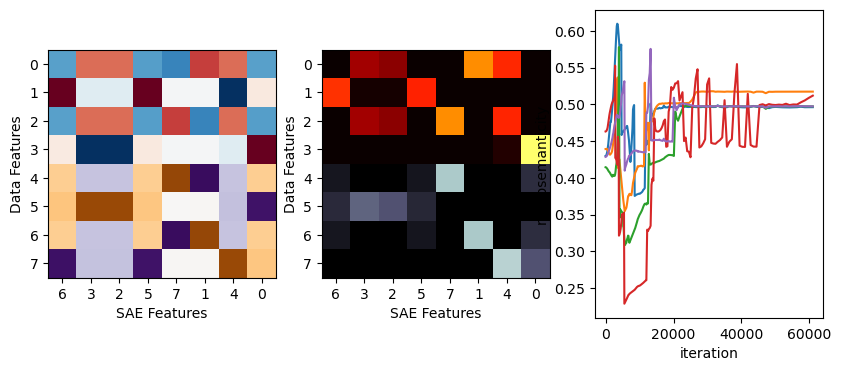

In [11]:
lr=3e-4
l1_coeff = 0.3
d_sae = feats_per_set*2

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 64_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

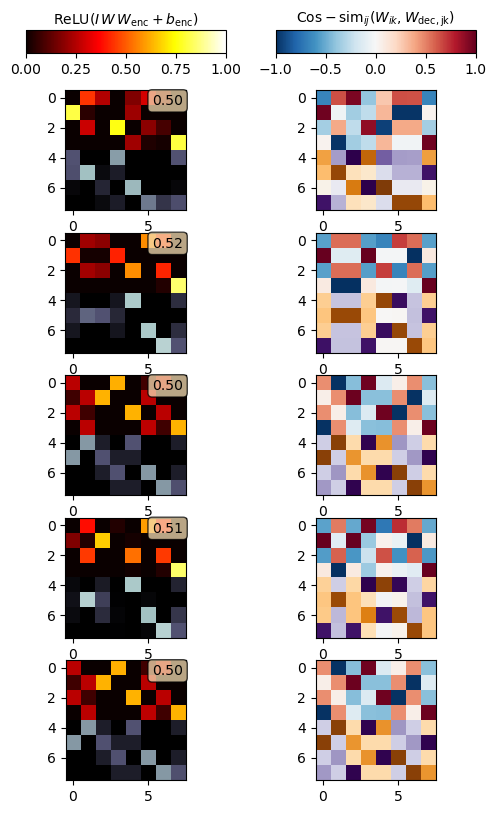

In [12]:

plot_sae_imshows(single_sae, model, sae_log)

# Small composed models (16 features, 2 sets)

## Uncorrelated feature amplitudes

### Model and simple SAEs

In [13]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
feats_per_set = 8
correlated_feature_indices = (feats_per_set-1, 0)
cfg = ToyModelConfig(hidden_size=feats_per_set,
                     feat_sets=(feats_per_set,feats_per_set),
                     batches=10000, 
                     batch_size=1000,
                     correlated_feature_indices=correlated_feature_indices,
                     correlated_feature_boost=0,
                     set_magnitude_correlation=0,
                     active_features_per_draw=1, # seems important for getting composed pairs.
                     )

model = ComposedFeatureTMS(cfg).to(device)
try:
    print('attempting to load')
    model.load(outdir, run_name=cfg.run_name)
except:
    print('training')
    model.train(outdir=outdir)

          y1        y2        y3        y4        y5        y6        y7        y8        
x1        0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    
x2        0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    
x3        0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    
x4        0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    
x5        0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    
x6        0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    
x7        0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    
x8        0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    
attempting to load


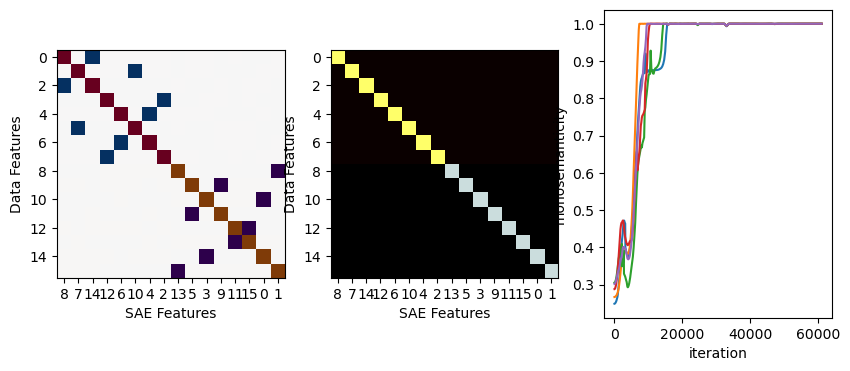

In [14]:
lr=3e-4
l1_coeff = 0.3
d_sae = feats_per_set*2

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 64_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

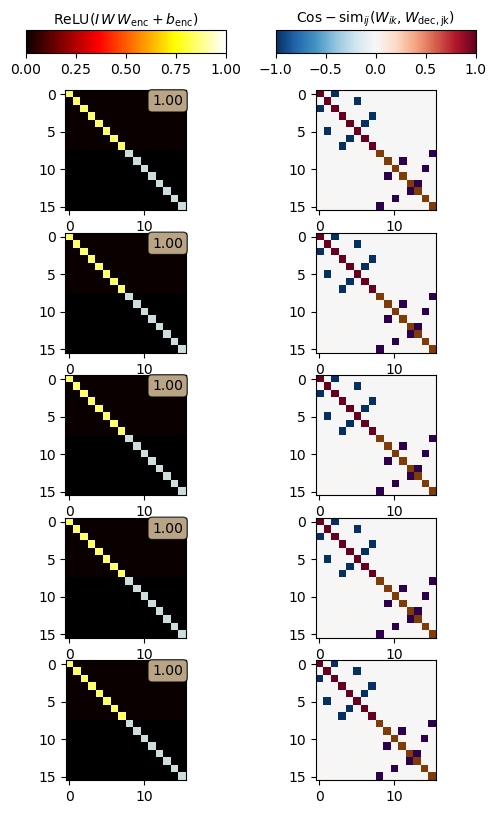

In [15]:

plot_sae_imshows(single_sae, model, sae_log)

### Model and simple SAEs (6 hidden dims)

Note 7 hidden dims is kinda interesting cause one block is antipodal.

In [16]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
hidden_size = 6
feats_per_set = 8
correlated_feature_indices = (feats_per_set-1, 0)
cfg = ToyModelConfig(hidden_size=hidden_size,
                     feat_sets=(feats_per_set,feats_per_set),
                     batches=10000, 
                     batch_size=1000,
                     correlated_feature_indices=correlated_feature_indices,
                     correlated_feature_boost=0,
                     set_magnitude_correlation=0,
                     active_features_per_draw=1, # seems important for getting composed pairs.
                     )

model = ComposedFeatureTMS(cfg).to(device)
try:
    print('attempting to load')
    model.load(outdir, run_name=cfg.run_name)
except:
    print('training')
    model.train(outdir=outdir)

          y1        y2        y3        y4        y5        y6        y7        y8        
x1        0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    
x2        0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    
x3        0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    
x4        0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    
x5        0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    
x6        0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    
x7        0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    
x8        0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    0.0156    
attempting to load


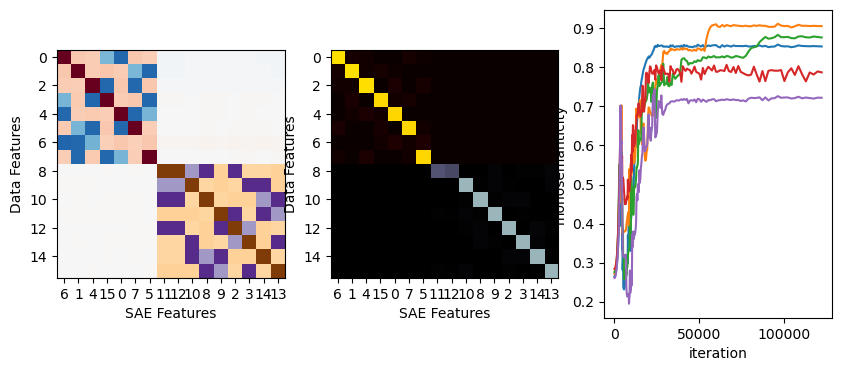

In [17]:
lr=3e-4
l1_coeff = 0.8 #0.3-0.5 does not produce sparsity OR composed pairs!
d_sae = feats_per_set*2

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 128_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0.9,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

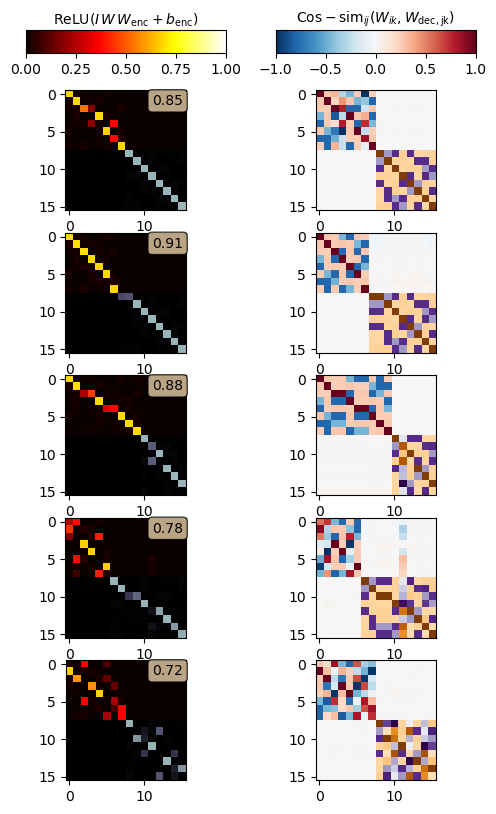

In [18]:

plot_sae_imshows(single_sae, model, sae_log)

### Model and simple SAEs (4 hidden dims)

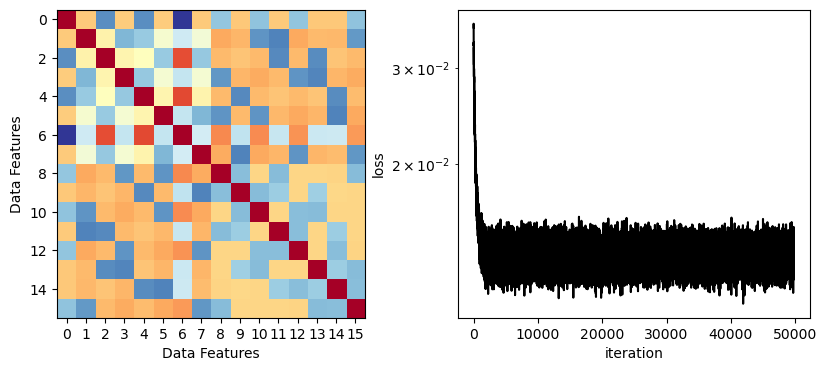

In [22]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
hidden_size = 4
feats_per_set = 8
correlated_feature_indices = (feats_per_set-1, 0)
cfg = ToyModelConfig(hidden_size=hidden_size,
                     feat_sets=(feats_per_set,feats_per_set),
                     batches=50000, 
                     batch_size=1000,
                     correlated_feature_indices=correlated_feature_indices,
                     correlated_feature_boost=0,
                     set_magnitude_correlation=0,
                     active_features_per_draw=1, # seems important for getting composed pairs.
                     )

model = ComposedFeatureTMS(cfg).to(device)
try:
    print('attempting to load')
    model.load(outdir, run_name=cfg.run_name)
except:
    print('training')
    model.train(outdir=outdir)

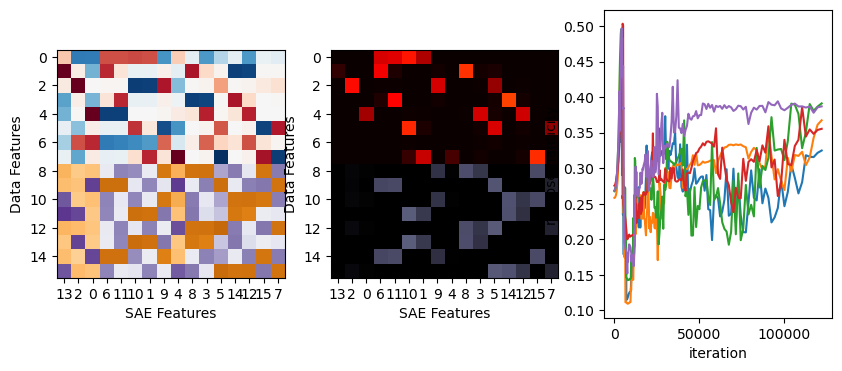

In [26]:
lr=3e-4
l1_coeff = 0.5
d_sae = feats_per_set*2

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 128_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0.9,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

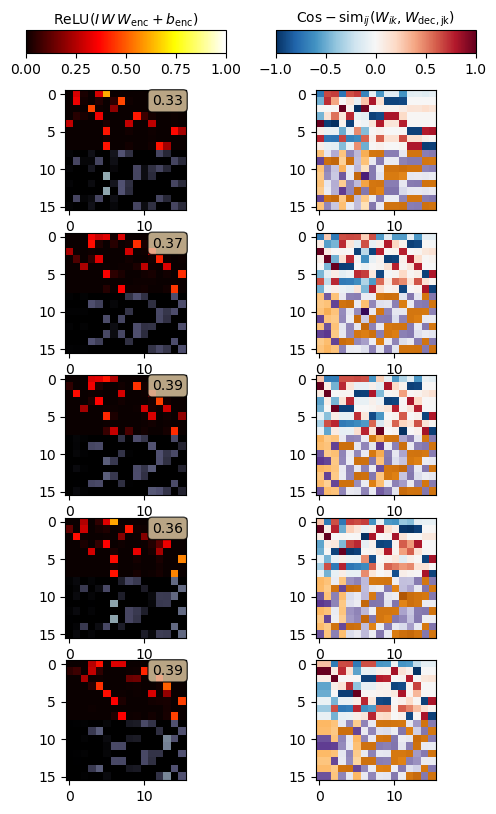

In [27]:

plot_sae_imshows(single_sae, model, sae_log)

## One increasingly correlated feature pair; correlated magnitudes.(8x2 in 6)

### Model and simple SAEs

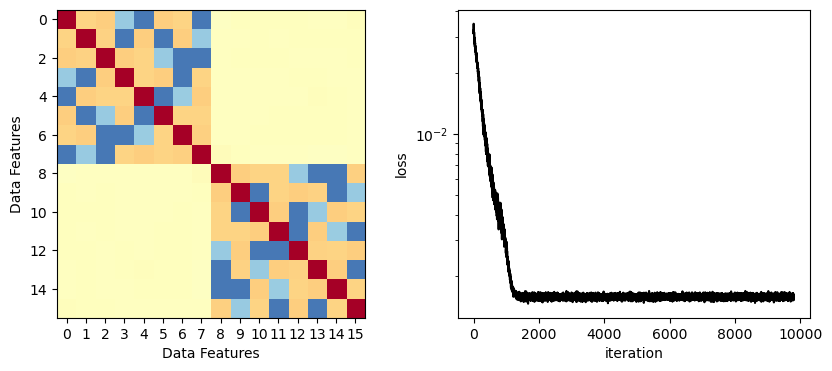

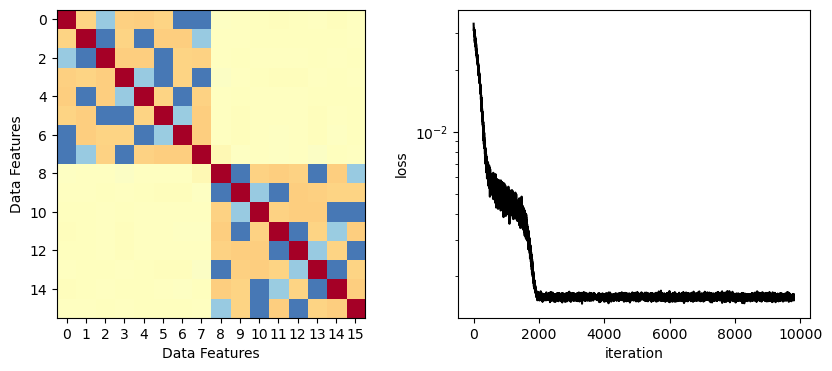

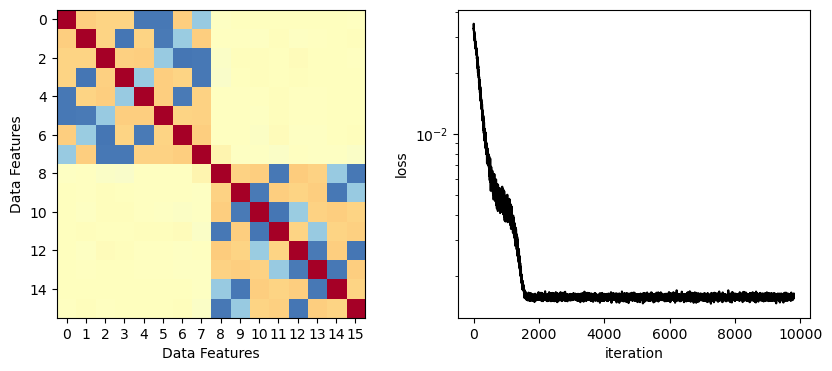

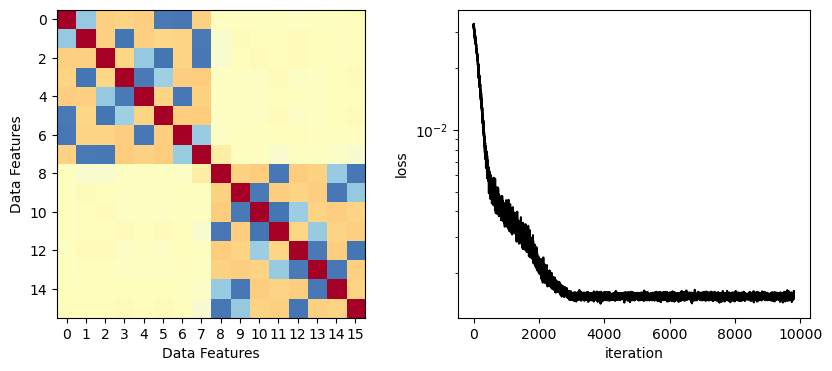

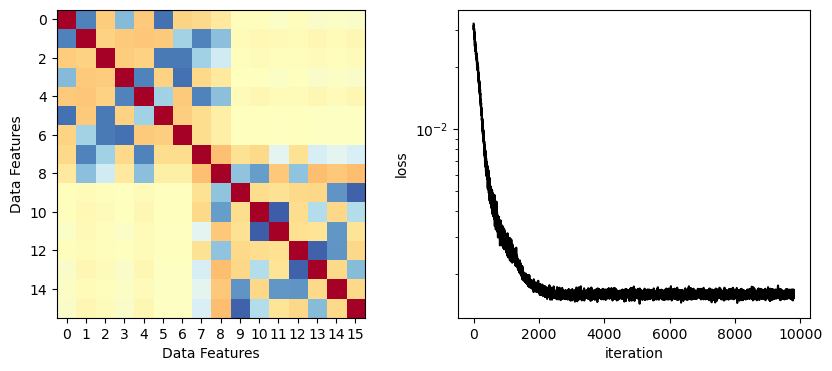

In [29]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
feats_per_set = 8
hidden_size=6
correlations = [0.2, 0.4, 0.6, 0.8, 0.99]
correlated_models = []
correlated_feature_indices = (feats_per_set-1, 0)

for corr in correlations:
    cfg = ToyModelConfig(hidden_size=hidden_size,
                         feat_sets=(feats_per_set,feats_per_set),
                         batches=10000, 
                         batch_size=1000,
                         correlated_feature_indices=correlated_feature_indices,
                         correlated_feature_boost=corr,
                         set_magnitude_correlation=0,
                         active_features_per_draw=1, # seems important for getting composed pairs.
                         )
    
    model = ComposedFeatureTMS(cfg).to(device)
    try:
        print('attempting to load')
        model.load(outdir, run_name=cfg.run_name)
    except:
        print('training')
        model.train(outdir=outdir)
    correlated_models.append(model)

TODO: Re-run below!! I was always using the last (most correlated) model last time I ran this.

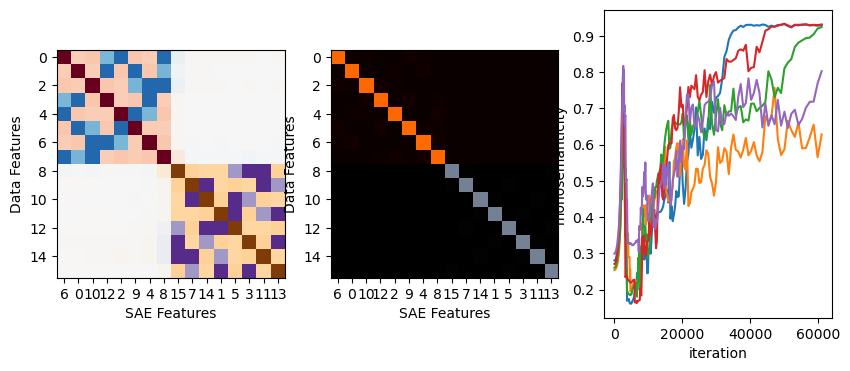

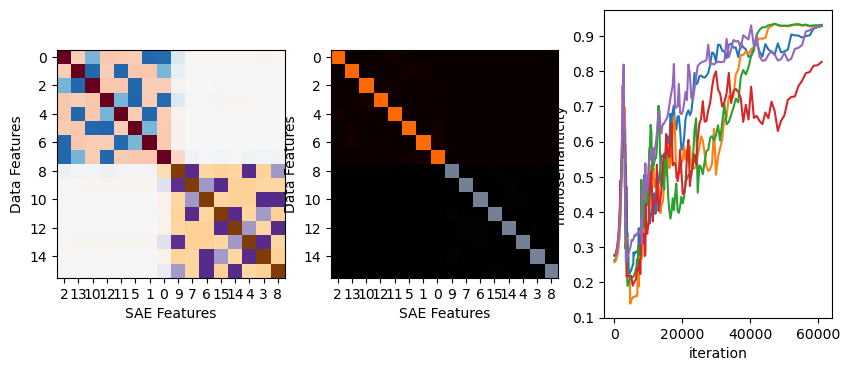

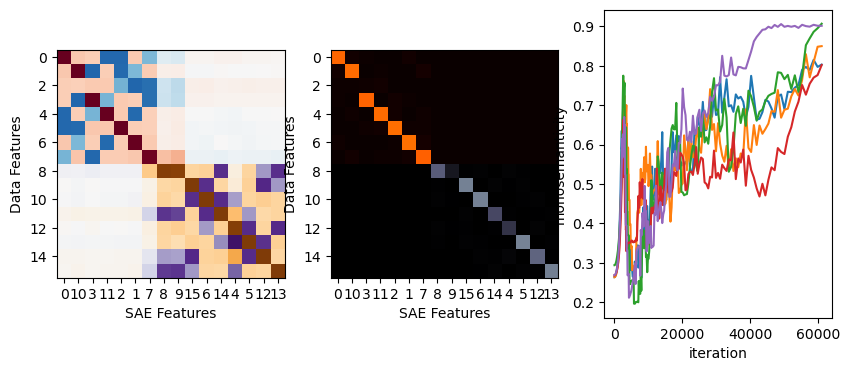

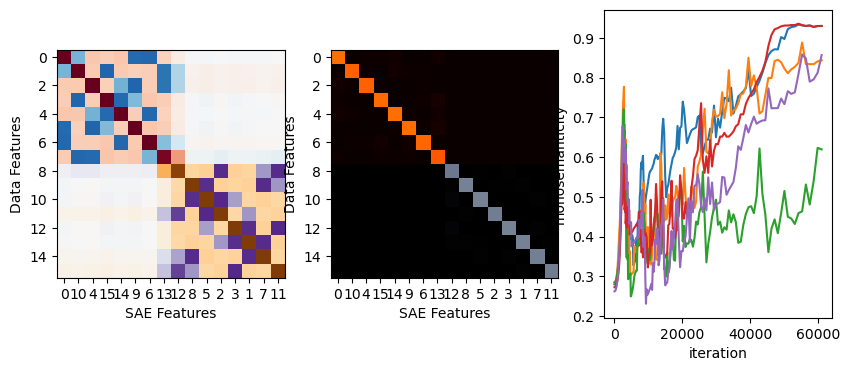

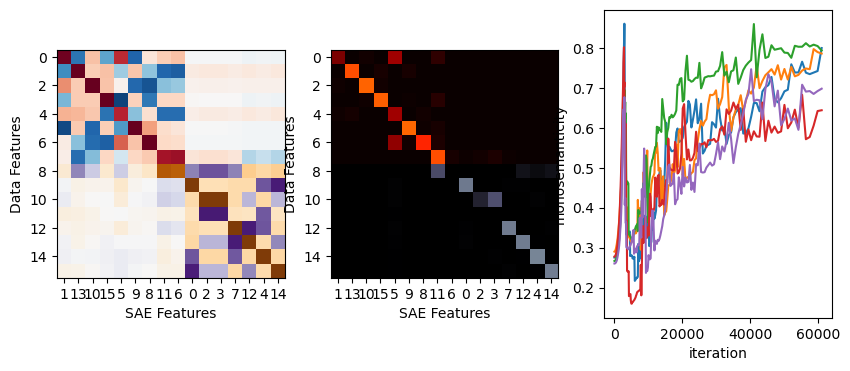

In [30]:
lr=3e-4
l1_coeff = 1
d_sae = feats_per_set*2

saes = []
sae_logs = []
for i, corr in enumerate(correlations):
    model = correlated_models[i] #TODO: I just added this; need to re-run!
    #can add a loop here and append
    proj_name = f"autoencoder-uncorrelated"
    en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                            n_inst=5,
                            training_samples = 64_000_000,
                            dict_mult=d_sae/cfg.hidden_size,
                            lr=lr,
                            adam_beta1=0,
                            wandb_project=proj_name,
                            l1_coeff=l1_coeff,
                            pre_encoder_bias=False
                            )
    print('running {}'.format(en_cfg.run_name))
    encoder = AutoEncoder(en_cfg).to(device)
    # help(encoder.train)
    outdir = rootdir/'8_in_6_saes_corr{:.2f}'.format(corr)
    outdir.mkdir(exist_ok=True)
    sae_log = encoder.train(model,rootdir=outdir, plot_cadence=1000)
    saes.append((encoder, model))
    sae_logs.append(sae_log)

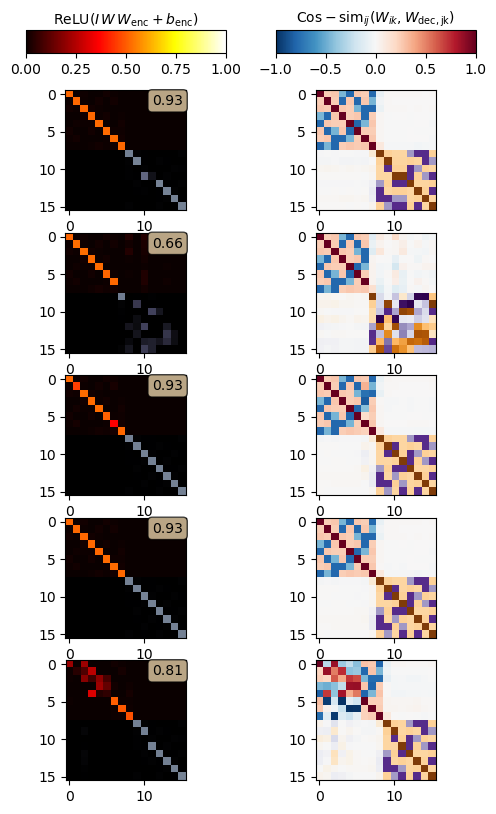

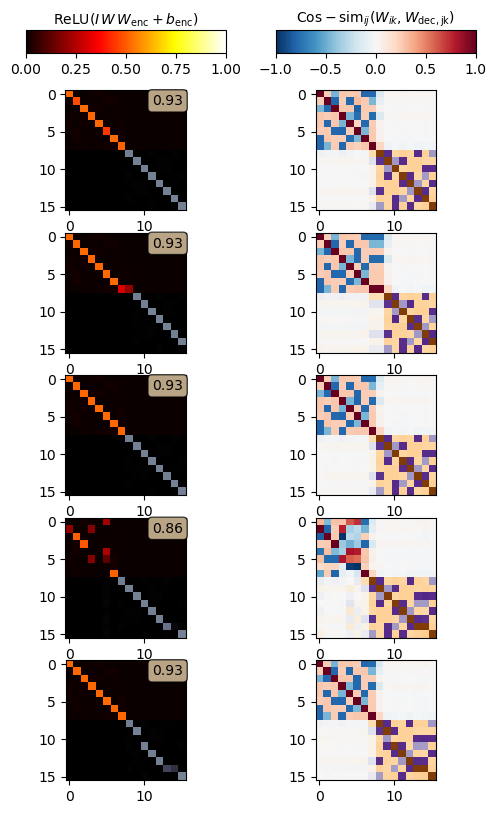

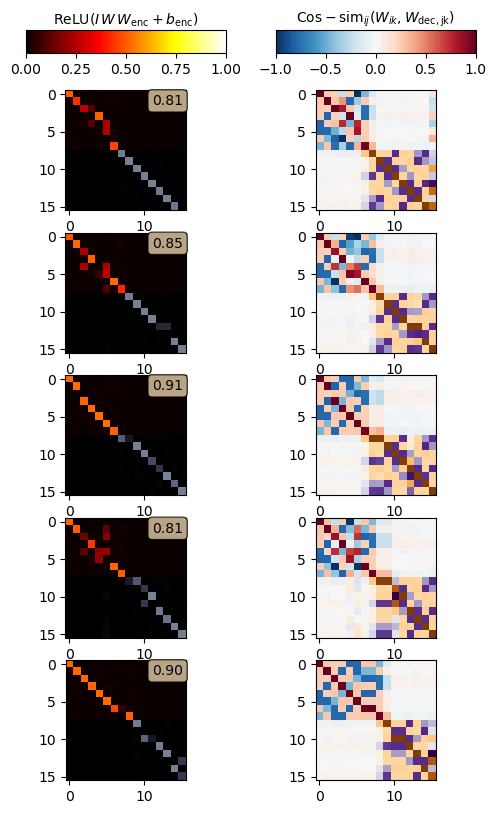

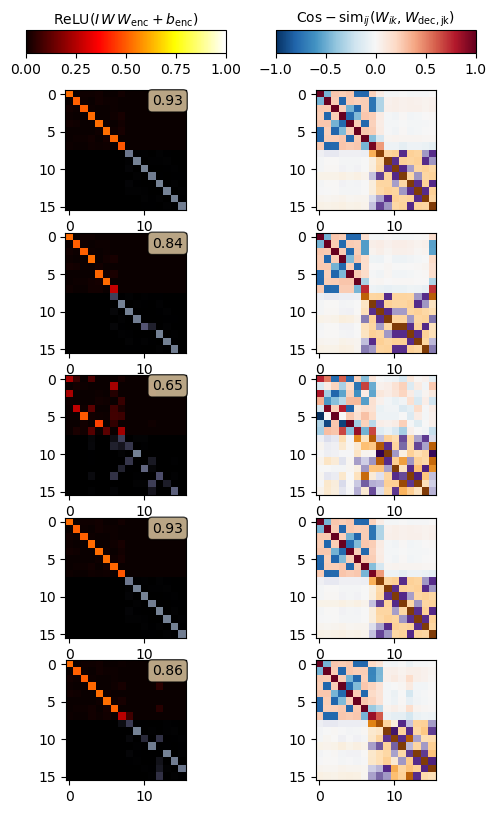

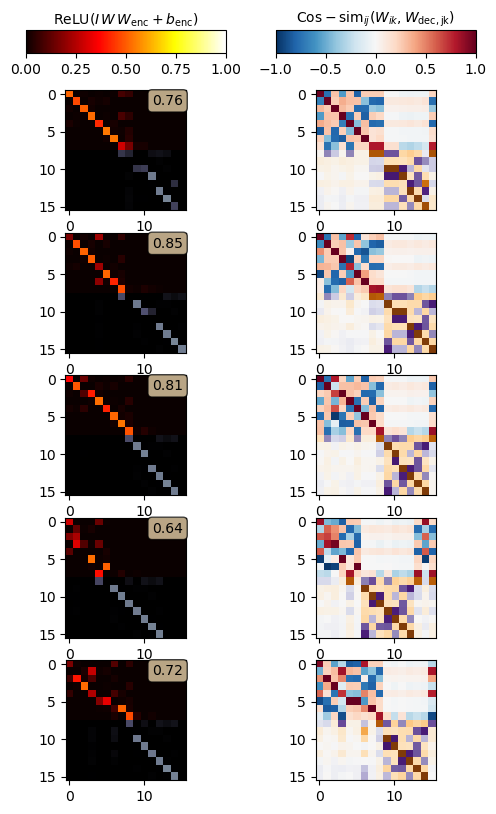

In [31]:
for i, corr in enumerate(correlations):
    plot_sae_imshows(saes[i][0], correlated_models[i], sae_logs[i])

## One increasingly correlated feature pair; correlated magnitudes.(8x2 in 5)

### Model and simple SAEs

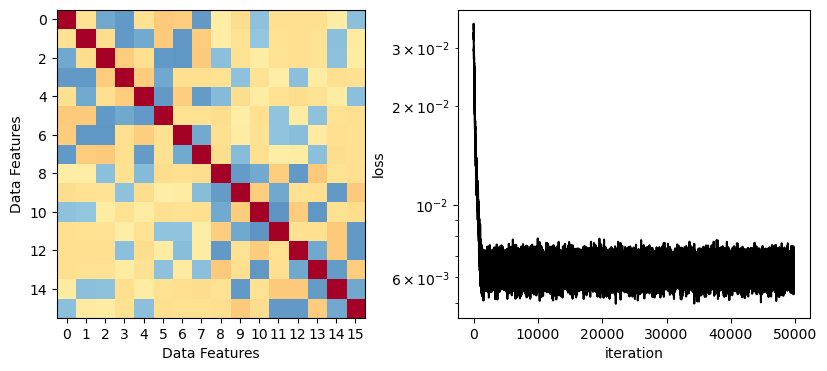

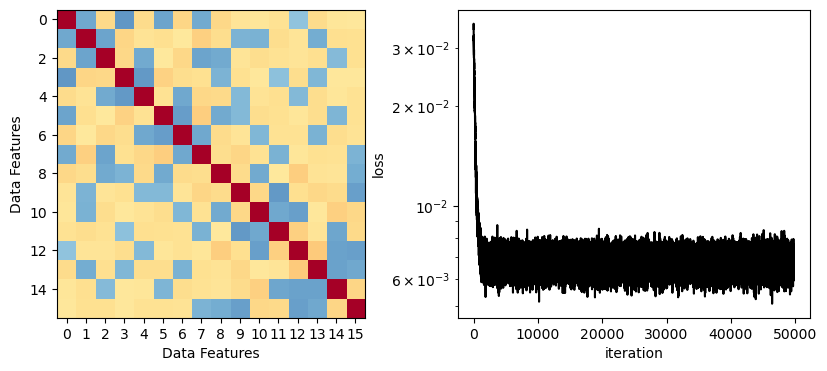

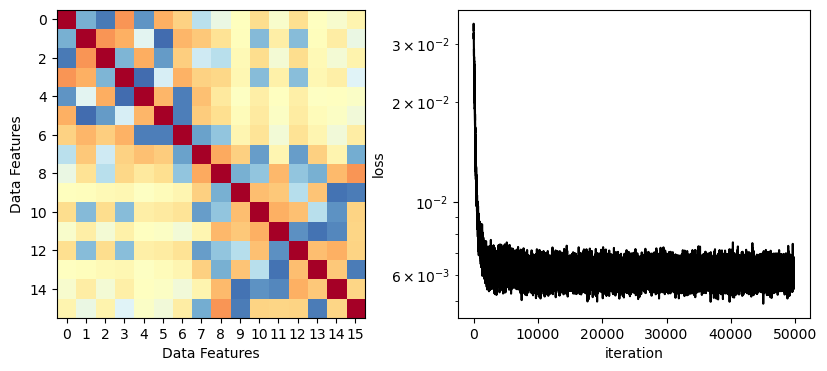

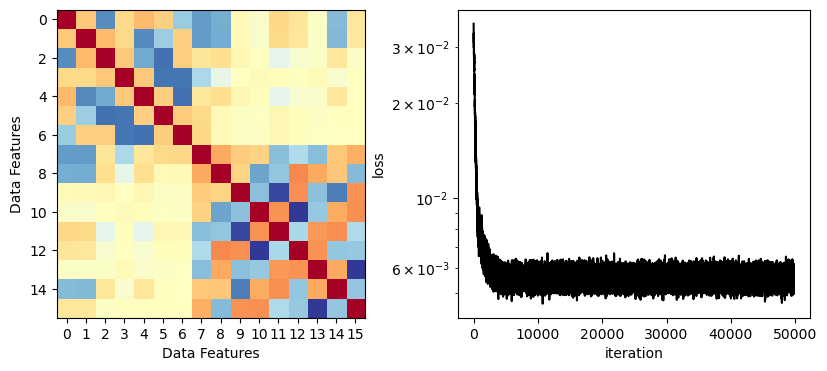

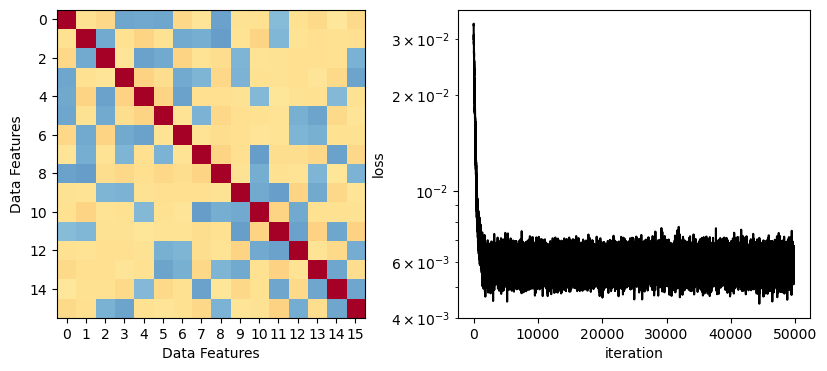

In [33]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
feats_per_set = 8
hidden_size=5
correlations = [0.2, 0.4, 0.6, 0.8, 0.99]
correlated_models = []
correlated_feature_indices = (feats_per_set-1, 0)

for corr in correlations:
    cfg = ToyModelConfig(hidden_size=hidden_size,
                         feat_sets=(feats_per_set,feats_per_set),
                         batches=50000, 
                         batch_size=1000,
                         correlated_feature_indices=correlated_feature_indices,
                         correlated_feature_boost=corr,
                         set_magnitude_correlation=0,
                         active_features_per_draw=1, # seems important for getting composed pairs.
                         )
    
    model = ComposedFeatureTMS(cfg).to(device)
    try:
        print('attempting to load')
        model.load(outdir, run_name=cfg.run_name)
    except:
        print('training')
        model.train(outdir=outdir)
    correlated_models.append(model)

TODO: Re-run below!! I was always using the last (most correlated) model last time I ran this.

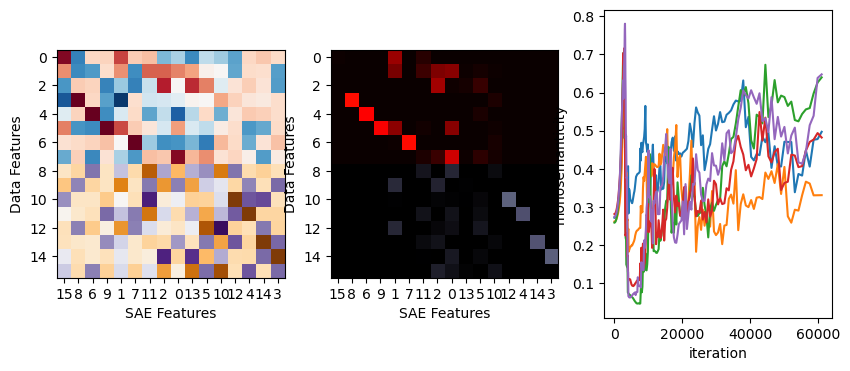

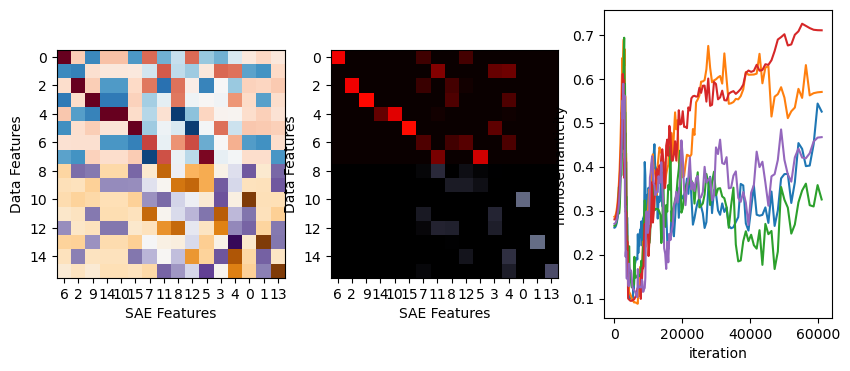

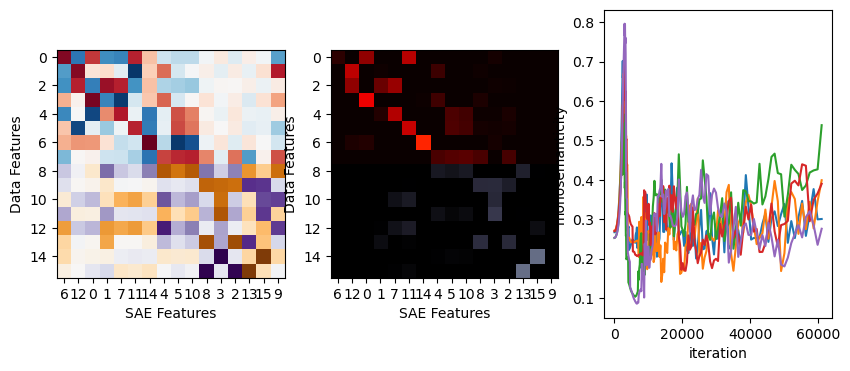

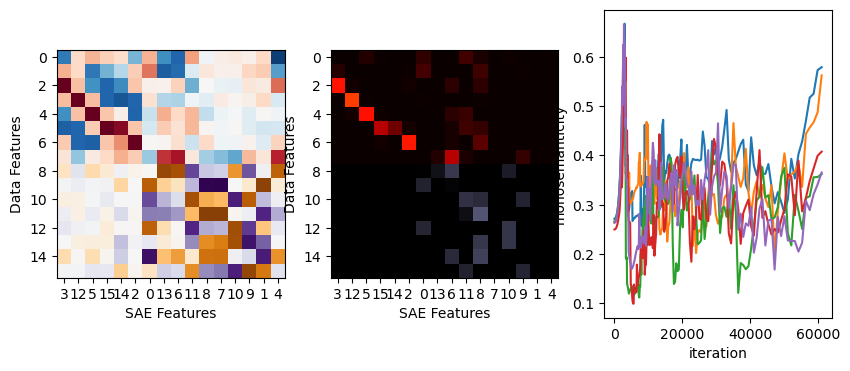

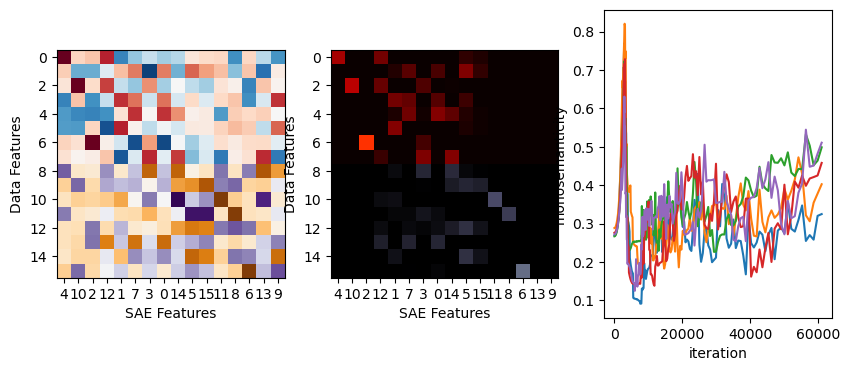

In [34]:
lr=3e-4
l1_coeff = 1
d_sae = feats_per_set*2

saes = []
sae_logs = []
for i, corr in enumerate(correlations):
    model = correlated_models[i] #TODO: I just added this; need to re-run!
    #can add a loop here and append
    proj_name = f"autoencoder-uncorrelated"
    en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                            n_inst=5,
                            training_samples = 64_000_000,
                            dict_mult=d_sae/cfg.hidden_size,
                            lr=lr,
                            adam_beta1=0,
                            wandb_project=proj_name,
                            l1_coeff=l1_coeff,
                            pre_encoder_bias=False
                            )
    print('running {}'.format(en_cfg.run_name))
    encoder = AutoEncoder(en_cfg).to(device)
    # help(encoder.train)
    outdir = rootdir/'8_in_6_saes_corr{:.2f}'.format(corr)
    outdir.mkdir(exist_ok=True)
    sae_log = encoder.train(model,rootdir=outdir, plot_cadence=1000)
    saes.append((encoder, model))
    sae_logs.append(sae_log)

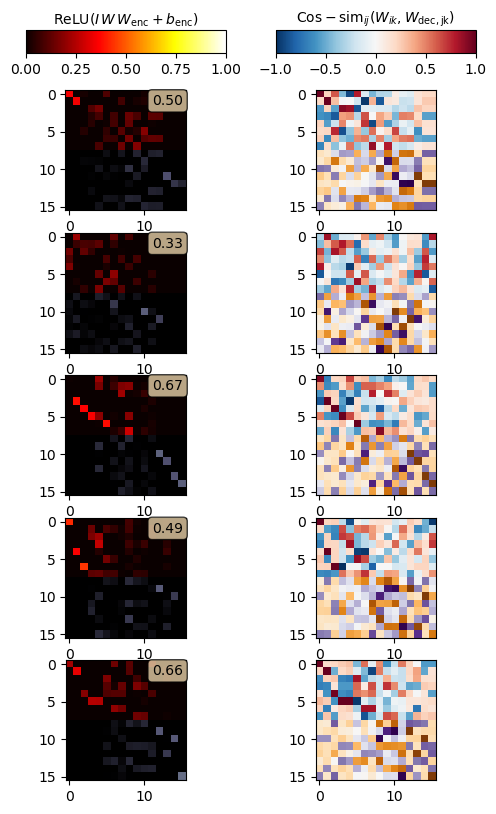

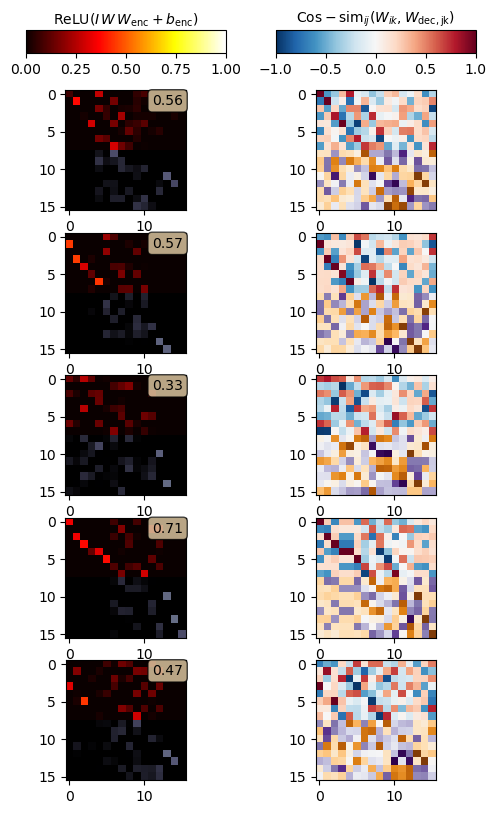

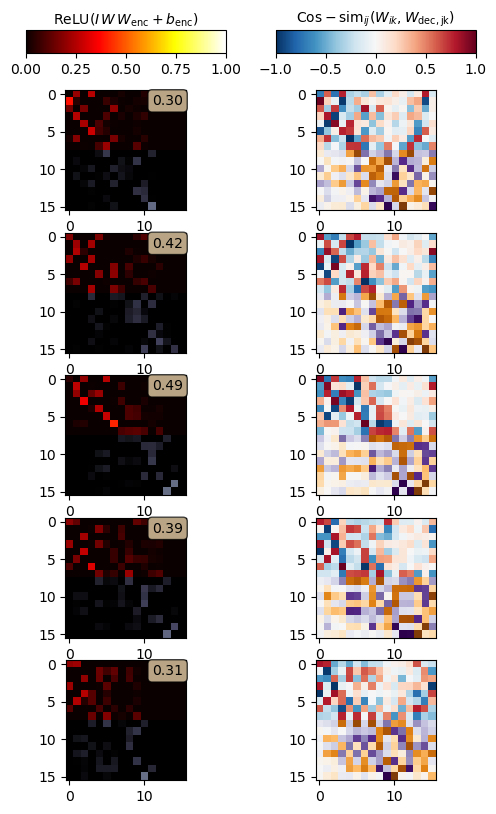

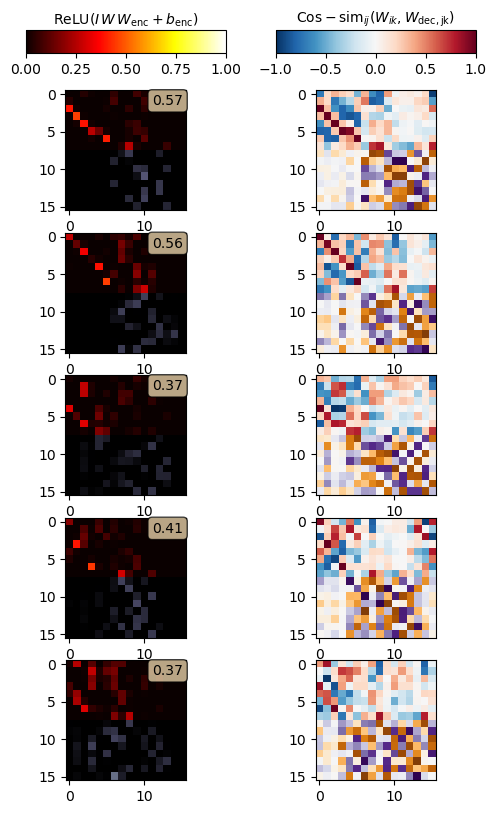

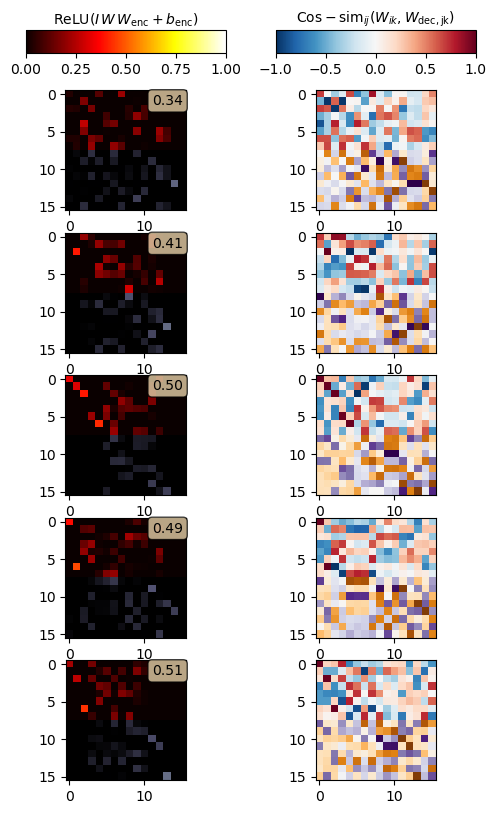

In [35]:
for i, corr in enumerate(correlations):
    plot_sae_imshows(saes[i][0], correlated_models[i], sae_logs[i])

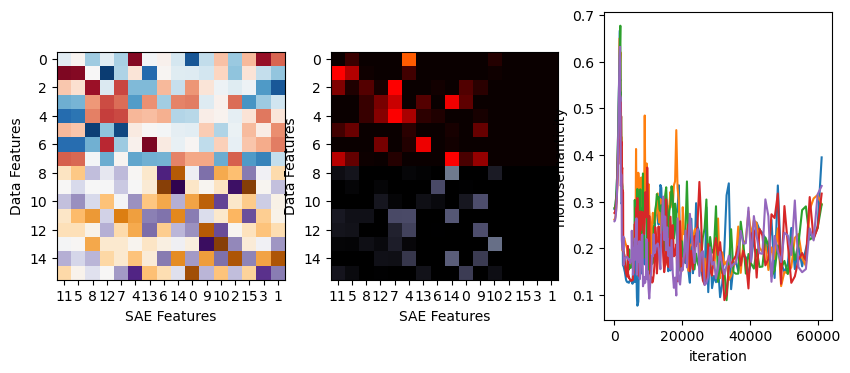

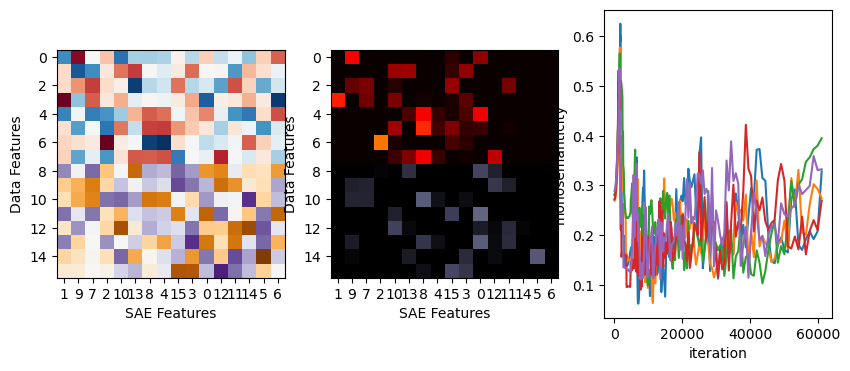

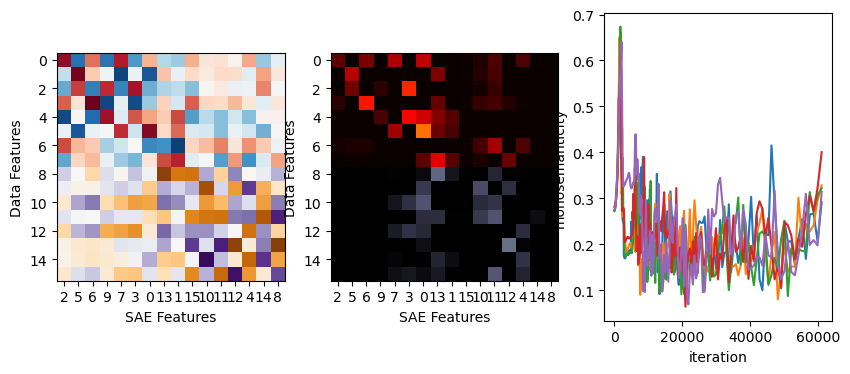

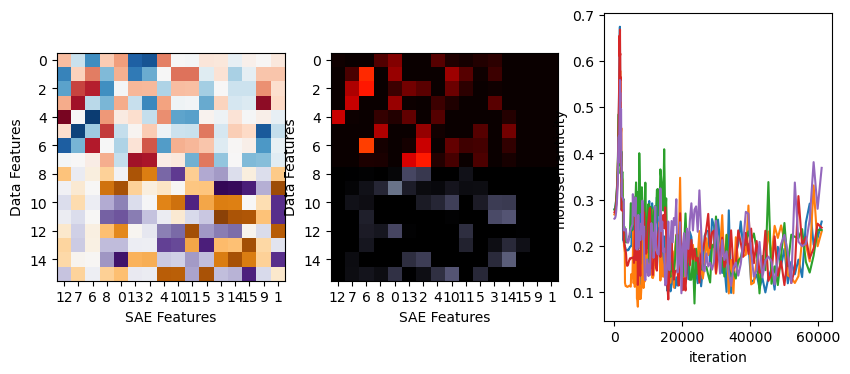

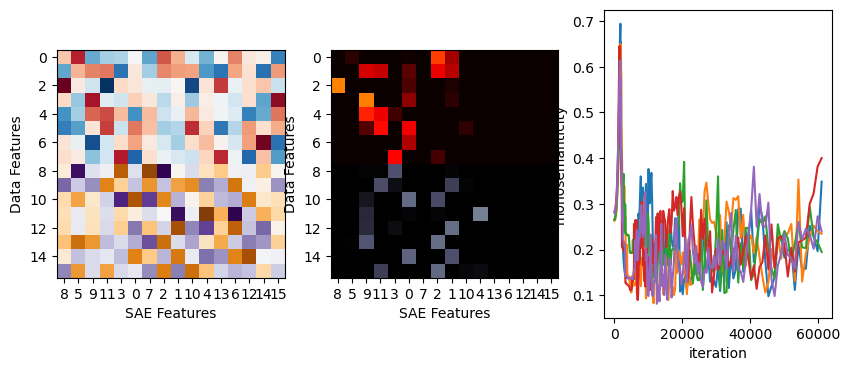

In [40]:
lr=1e-3
l1_coeff = 0.8
d_sae = feats_per_set*2

saes = []
sae_logs = []
for i, corr in enumerate(correlations):
    model = correlated_models[i] #TODO: I just added this; need to re-run!
    #can add a loop here and append
    proj_name = f"autoencoder-uncorrelated"
    en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                            n_inst=5,
                            training_samples = 64_000_000,
                            dict_mult=d_sae/cfg.hidden_size,
                            lr=lr,
                            adam_beta1=0,
                            wandb_project=proj_name,
                            l1_coeff=l1_coeff,
                            pre_encoder_bias=False
                            )
    print('running {}'.format(en_cfg.run_name))
    encoder = AutoEncoder(en_cfg).to(device)
    # help(encoder.train)
    outdir = rootdir/'8_in_6_saes_corr{:.2f}'.format(corr)
    outdir.mkdir(exist_ok=True)
    sae_log = encoder.train(model,rootdir=outdir, plot_cadence=1000)
    saes.append((encoder, model))
    sae_logs.append(sae_log)

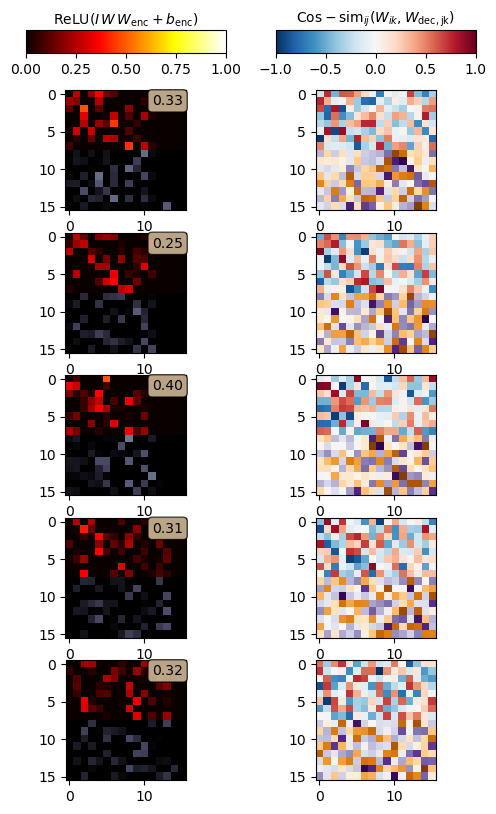

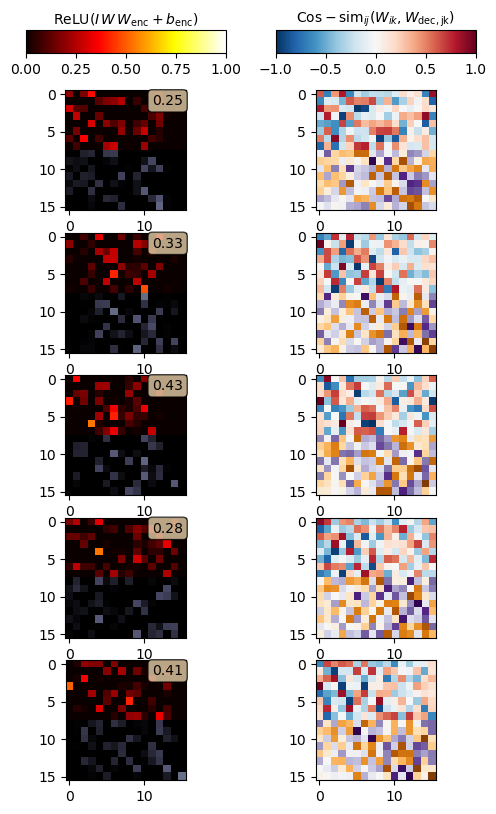

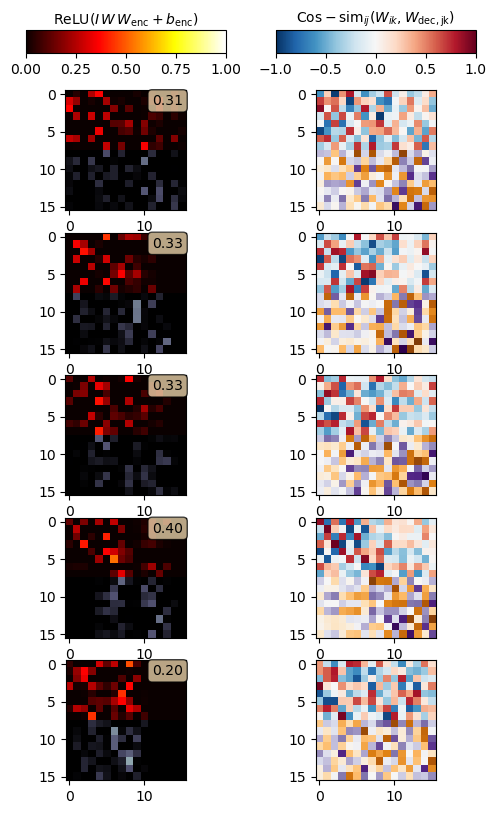

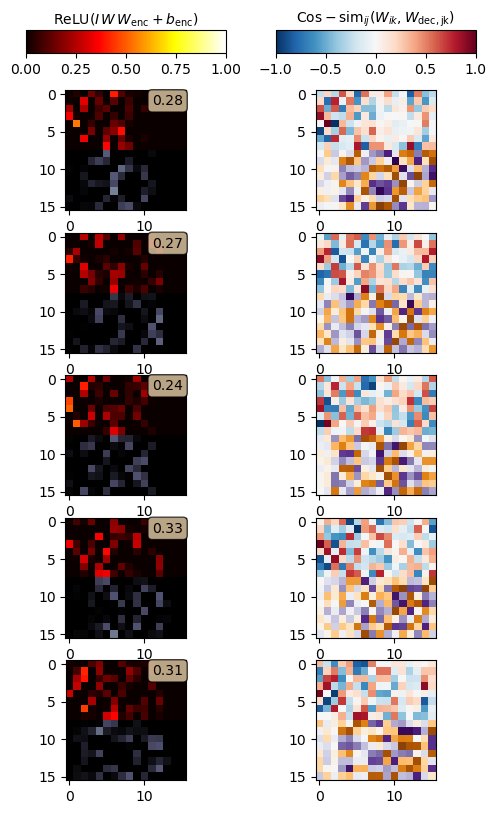

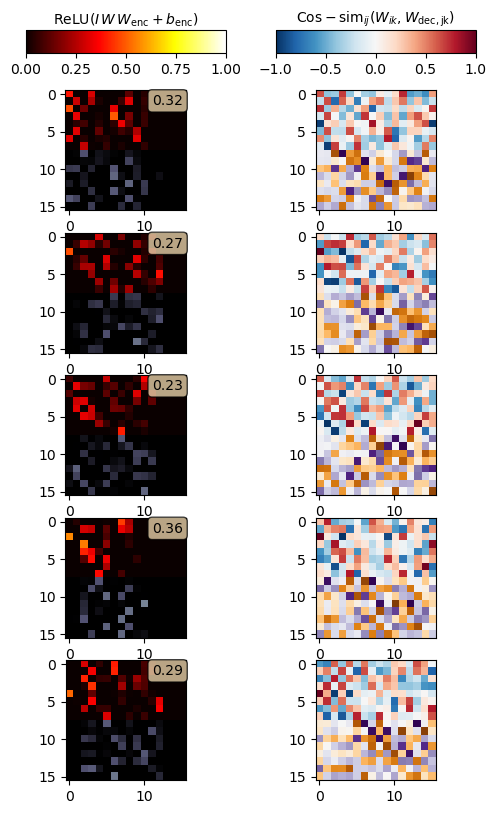

In [41]:
for i, corr in enumerate(correlations):
    plot_sae_imshows(saes[i][0], correlated_models[i], sae_logs[i])